In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats
from nba_api.stats.endpoints.leaguehustlestatsteam import LeagueHustleStatsTeam
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats

In [4]:
df = pd.read_csv('pbp_data/2022-23.csv')

In [5]:
full_df = pd.read_csv('pbp_data/2022-23.csv')

full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]

In [6]:
full_df.loc[(full_df.EVENTMSGTYPE == 6) & (full_df.PLAYER2_NAME == 'Chris Paul'), ['EVENTMSGACTIONTYPE', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION', 'PLAYER1_NAME', 'PLAYER2_NAME']]

,EVENTMSGACTIONTYPE,HOMEDESCRIPTION,VISITORDESCRIPTION,PLAYER1_NAME,PLAYER2_NAME
16861,1,LeVert P.FOUL (P1.T2) (J.Capers),,Caris LeVert,Chris Paul
16943,1,Okoro P.FOUL (P1.PN) (J.Capers),,Isaac Okoro,Chris Paul
17092,2,Neto S.FOUL (P2.T1) (S.Corbin),,Raul Neto,Chris Paul
28684,2,Quickley S.FOUL (P1.T3) (B.Taylor),,Immanuel Quickley,Chris Paul
35652,2,Koloko S.FOUL (P3.PN) (J.Tiven),,Christian Koloko,Chris Paul
35657,1,Young P.FOUL (P1.PN) (J.Van Duyne),,Thaddeus Young,Chris Paul
35754,1,Flynn P.FOUL (P2.PN) (R.Hussey),,Malachi Flynn,Chris Paul
42276,1,Morris P.FOUL (P1.T1) (Z.Zarba),,Monte Morris,Chris Paul
42395,2,Kuzma S.FOUL (P2.T2) (C.Washington),,Kyle Kuzma,Chris Paul
47737,26,Morant Offensive Charge Foul (P1) (N.Green),,Ja Morant,Chris Paul


In [7]:
 full_df.loc[(full_df.EVENTMSGTYPE == 6) &  ((full_df.HOMEDESCRIPTION.str.contains('.PN')) | (full_df.VISITORDESCRIPTION.str.contains('.PN'))), ['EVENTMSGACTIONTYPE', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION', 'PLAYER1_NAME', 'PLAYER2_NAME']].EVENTMSGACTIONTYPE.unique()

array([ 3,  1, 28,  2, 31, 14, 11, 12, 15,  6,  9], dtype=int64)

In [8]:
penalty_fouls = full_df.loc[(full_df.EVENTMSGTYPE == 6) & (full_df.EVENTMSGACTIONTYPE == 1) & ((full_df.HOMEDESCRIPTION.str.contains('.PN')) | (full_df.VISITORDESCRIPTION.str.contains('.PN')))]

In [9]:
fouls_df = penalty_fouls.groupby(['PLAYER2_ID', 'PLAYER2_NAME']).size().reset_index().rename(columns={0: 'FOULS_DRAWN_REGULAR_PENALTY'})

In [10]:
top_players = fouls_df.sort_values(by='FOULS_DRAWN_REGULAR_PENALTY', ascending=False).iloc[:15]

In [11]:
plt.style.use('fivethirtyeight')

In [12]:
from matplotlib.patches import Rectangle

In [13]:
all_fouls = full_df.loc[full_df.EVENTMSGTYPE == 6]

In [14]:
total_fouls_drawn = all_fouls.groupby(['PLAYER2_ID', 'PLAYER2_NAME']).size().reset_index().rename(columns={0: 'FOULS_DRAWN'})

In [15]:
regular_personal_fouls = full_df.loc[(full_df.EVENTMSGTYPE == 6) & (full_df.EVENTMSGACTIONTYPE == 1)]

In [16]:
total_regular_fouls_drawn = regular_personal_fouls.groupby(['PLAYER2_ID', 'PLAYER2_NAME']).size().reset_index().rename(columns={0: 'FOULS_DRAWN_REGULAR'})

In [17]:
merged_df = pd.merge(left=total_fouls_drawn, right=fouls_df, on=['PLAYER2_ID', 'PLAYER2_NAME'])

In [18]:
merged_df = pd.merge(left=merged_df, right=total_regular_fouls_drawn, on=['PLAYER2_ID', 'PLAYER2_NAME'])

In [19]:
top_players = merged_df.sort_values(by='FOULS_DRAWN_REGULAR_PENALTY', ascending=False).iloc[:15]

In [20]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.125

player_root_dir = f'player_imgs/'
team_root_dir = f'../../team_logos_id/'

def get_player_img(player_id, zoom=0.55):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id, zoom=zoom):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

In [21]:
top_players

,PLAYER2_ID,PLAYER2_NAME,FOULS_DRAWN,FOULS_DRAWN_REGULAR_PENALTY,FOULS_DRAWN_REGULAR
201,1629027,Trae Young,235,41,94
203,1629029,Luka Doncic,296,36,95
93,204001,Kristaps Porzingis,228,30,109
5,201142,Kevin Durant,236,28,93
92,203999,Nikola Jokic,234,26,108
47,203081,Damian Lillard,166,25,70
43,202711,Bojan Bogdanovic,152,25,64
86,203944,Julius Randle,218,23,62
146,1628378,Donovan Mitchell,166,23,70
88,203954,Joel Embiid,241,22,75


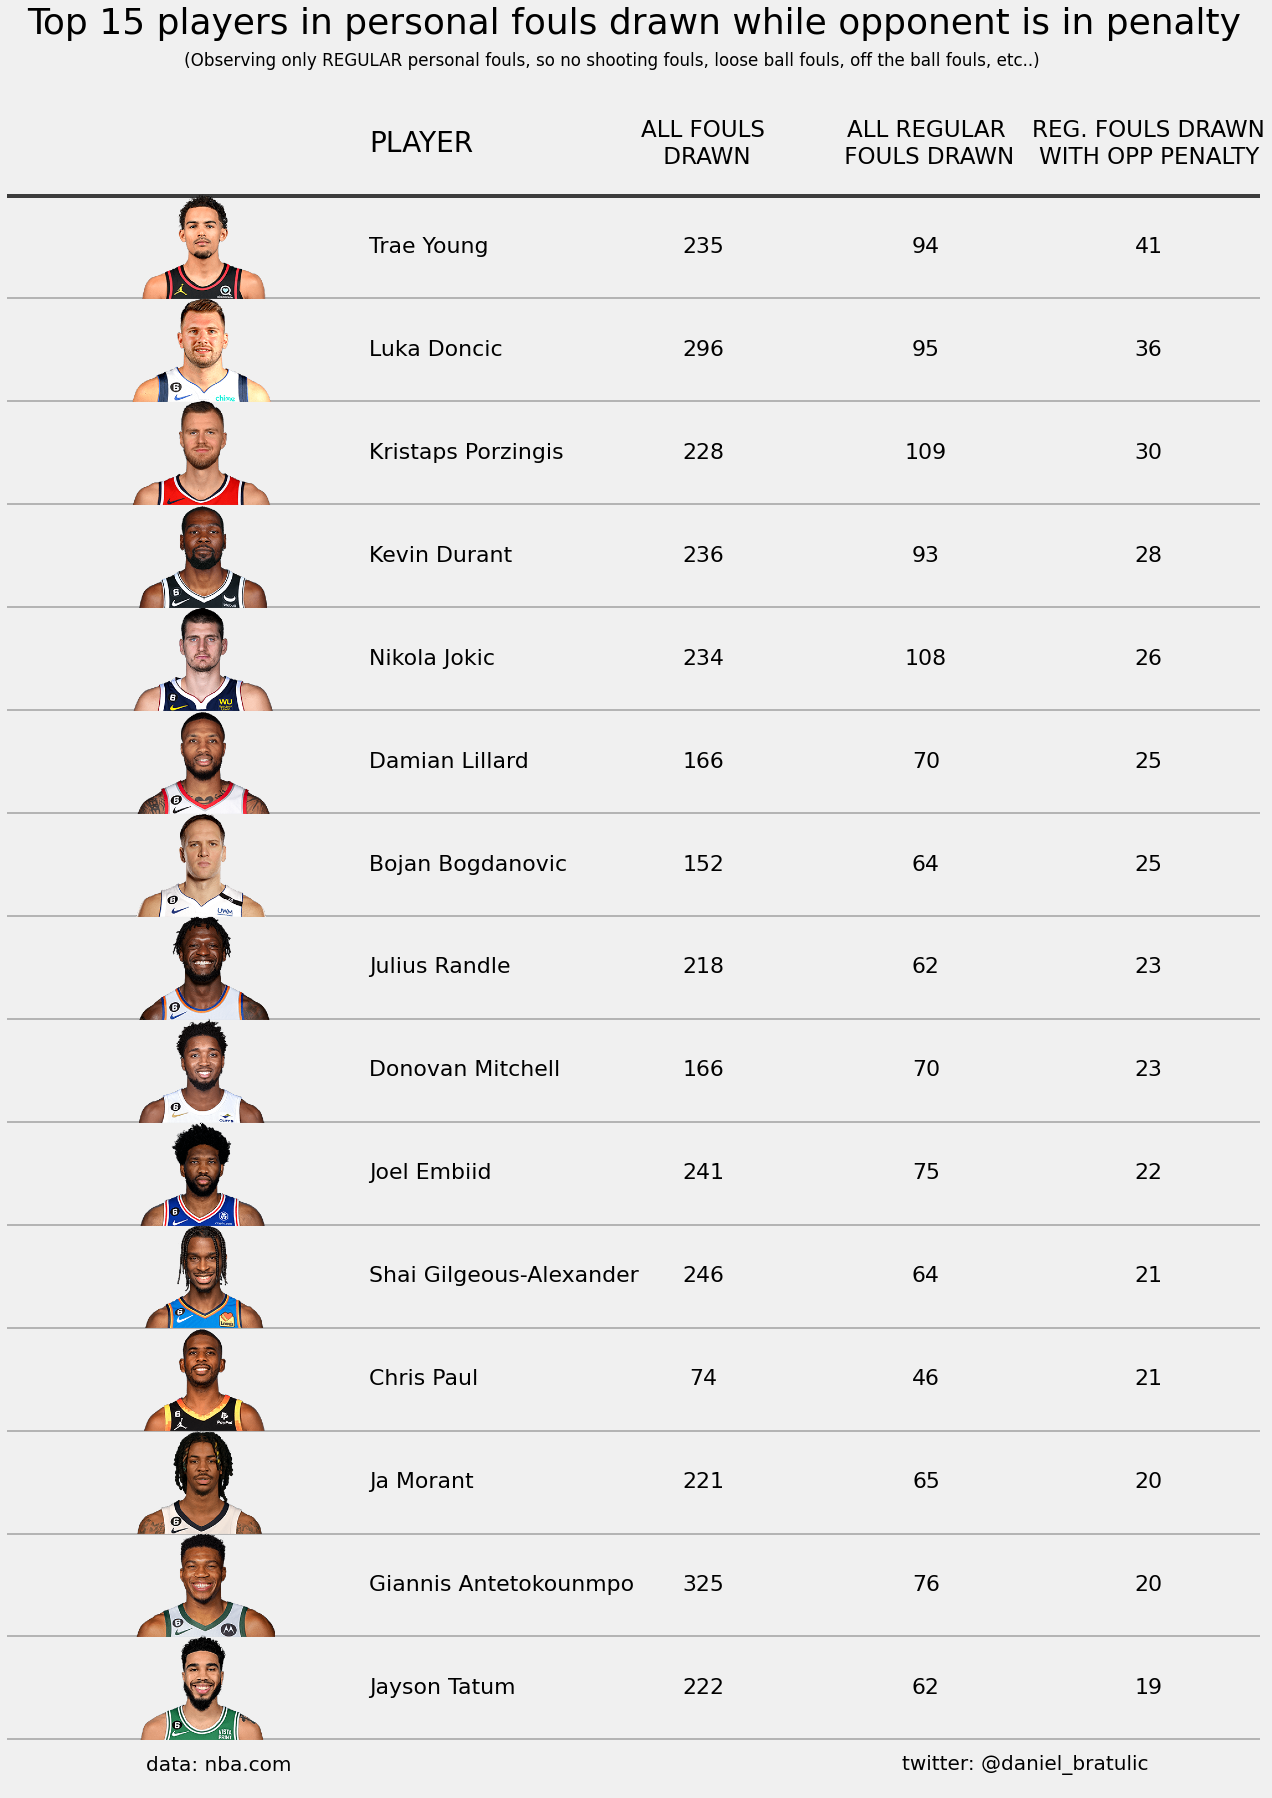

In [22]:
fig, ax = plt.subplots(figsize=(20, 30))
font_size = 22
font_title = 28
top = len(top_players)
#top = 10

for i in range(top):
    item = top_players.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        #rect = Rectangle((-0.5, y_coord + 0.5), width=5, height=1, fill=True, color=color)
        #ax.add_patch(rect)
    ab = AnnotationBbox(get_player_img(item.PLAYER2_ID), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.4, y=y_coord, ha='left', va='center', s=item.PLAYER2_NAME, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.0, y=y_coord, ha='center', va='center', s=item.FOULS_DRAWN, size=font_size)
    ax.text(x=1.4, y=y_coord, ha='center', va='center', s=item.FOULS_DRAWN_REGULAR, size=font_size)
    ax.text(x=1.8, y=y_coord, ha='center', va='center', s=item.FOULS_DRAWN_REGULAR_PENALTY, size=font_size)
    #ax.text(x=4, y=y_coord, ha='center', va='center', s=f"{item.SVI:.2f}", size=font_size)
    
    
    #ax.imshow(player_imgs[item.PLAYER_ID], extent=(0, 0.3, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    #ax.imshow(team_igms[item.TEAM_ID], extent=(2.3, 2.5, y_coord-0.35,y_coord + 0.35), aspect='auto', zorder=1)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
#ax.text(x=0.5, y=top, ha='center', va='center', s="TEAM", size=font_title)    
ax.text(x=0.4, y=top, s='PLAYER', ha='left', va='center', size=font_title)
ax.text(x=1.0, y=top, ha='center', va='center', s="ALL FOULS\n DRAWN", size=font_title-5)
ax.text(x=1.4, y=top, ha='center', va='center', s="ALL REGULAR\n FOULS DRAWN", size=font_title-5)
ax.text(x=1.8, y=top, ha='center', va='center', s="REG. FOULS DRAWN\nWITH OPP PENALTY", size=font_title-5)
#ax.text(x=1.8, y=top, ha='center', va='center', s="FOULS DRAWN\nWITH OPP PENALTY", size=font_title)
#ax.text(x=3.2, y=top, ha='center', va='center', s="MIN", size=font_title)
#ax.text(x=3.6, y=top, s='PPG', ha='center', va='center', size=font_title)
#ax.text(x=4, y=top, s='SVI', ha='center', va='center', size=font_title)

ax.text(x=1.8, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=20)
ax.text(x=0, y=-0.75, s='data: nba.com', ha='left', va='center', size=20)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Top 15 players in personal fouls drawn while opponent is in penalty", size=36)
plt.suptitle("(Observing only REGULAR personal fouls, so no shooting fouls, loose ball fouls, off the ball fouls, etc..)", y=0.875)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0.25, right=2.0)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('slika.png', dpi=120, bbox_inches='tight')

In [23]:
merged_df.sort_values(by='FOULS_DRAWN_REGULAR_PENALTY', ascending=False).iloc[:35]

,PLAYER2_ID,PLAYER2_NAME,FOULS_DRAWN,FOULS_DRAWN_REGULAR_PENALTY,FOULS_DRAWN_REGULAR
201,1629027,Trae Young,235,41,94
203,1629029,Luka Doncic,296,36,95
93,204001,Kristaps Porzingis,228,30,109
5,201142,Kevin Durant,236,28,93
92,203999,Nikola Jokic,234,26,108
47,203081,Damian Lillard,166,25,70
43,202711,Bojan Bogdanovic,152,25,64
86,203944,Julius Randle,218,23,62
146,1628378,Donovan Mitchell,166,23,70
88,203954,Joel Embiid,241,22,75
